In [1]:
import torch
import gfootball.env as football_env
import numpy as np
from torch.distributions import Categorical
import os # Added for checkpoint path handling

In [2]:
# --- Helper Functions/Classes (Copied from the notebook) ---

class ResidualBlock(torch.nn.Module):
    """Residual Block used in the ActorCritic network."""
    def __init__(self, channels):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3, padding=1)

    def forward(self, x):
        residual = x
        out = self.relu(x)
        out = self.conv1(out)
        out = self.relu(out)
        out = self.conv2(out+residual) # Apply residual connection after second conv
        return out

class ActorCritic(torch.nn.Module):
    """Actor-Critic network architecture from the notebook."""
    def __init__(self, input_shape, num_actions):
        super().__init__()
        C,H,W = input_shape
        self.num_actions = num_actions
        self.relu = torch.nn.ReLU()

        # Convolutional layers following the IMPALA architecture
        self.conv1 = torch.nn.Conv2d(in_channels=C, out_channels=16, kernel_size=3, stride=1) # Adjusted in_channels
        self.max1 = torch.nn.MaxPool2d(kernel_size=3, stride=2)
        self.res1a = ResidualBlock(16)
        self.res1b = ResidualBlock(16)

        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=0)
        self.max2 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.res2a = ResidualBlock(32)
        self.res2b = ResidualBlock(32)

        self.conv3 = torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.max3 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.res3a = ResidualBlock(32)
        self.res3b = ResidualBlock(32)

        self.conv4 = torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.max4 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.res4a = ResidualBlock(32)
        self.res4b = ResidualBlock(32)

        # Dynamically compute FC input size
        with torch.no_grad():
            # Create a dummy input tensor with the correct shape (Batch, Channels, Height, Width)
            dummy = torch.zeros(1, *input_shape)
            dummy = self.forward_conv(dummy)
            self.flattened_size = dummy.view(1, -1).size(1) # Calculate flattened size

        # Fully connected layers
        self.fc = torch.nn.Linear(self.flattened_size, 256)
        self.policy = torch.nn.Linear(256, num_actions) # Actor head
        self.value = torch.nn.Linear(256, 1) # Critic head

    def forward_conv(self, x):
        """Passes input through the convolutional layers."""
        x = self.conv1(x)
        x = self.max1(x)
        x = self.res1a(x)
        x = self.res1b(x)

        x = self.conv2(x)
        x = self.max2(x)
        x = self.res2a(x)
        x = self.res2b(x)

        x = self.conv3(x)
        x = self.max3(x)
        x = self.res3a(x)
        x = self.res3b(x)

        x = self.conv4(x)
        x = self.max4(x)
        x = self.res4a(x)
        x = self.res4b(x)
        return x

    def forward(self,x):
        """Forward pass through the network."""
        # Normalize pixel values (assuming input is uint8)
        if x.dtype == torch.uint8:
             x = x.float() / 255.0
        elif x.max() > 1.0: # Basic check if normalization is needed
             x = x / 255.0

        x = self.forward_conv(x)
        # Flatten the output for the fully connected layers
        x = x.reshape(x.size(0), -1)
        x = self.relu(self.fc(x))
        # Return policy logits and value prediction
        return self.policy(x), self.value(x)


In [131]:
# --- Testing Function ---
def test_model(model_path, scenario_name, num_episodes):
    """Loads a model and runs it for a specified number of episodes."""
    print(f"--- Starting Test ---")
    print(f"Scenario: {scenario_name}")
    print(f"Model: {model_path}")
    print(f"Episodes: {num_episodes}")

    # 1. Create the environment
    env = football_env.create_environment(
        env_name=scenario_name,
        representation='extracted',
        stacked=True,
        number_of_left_players_agent_controls=1,
        render=False, # Set to True if you want to watch the games
        rewards='scoring,checkpoints' # Rewards setting doesn't affect info['score']
    )

    # 2. Load the model
    # Determine input shape and number of actions from the environment
    obs_space_shape = env.observation_space.shape # (H, W, C)
    # Transpose shape for PyTorch (C, H, W)
    input_shape = (obs_space_shape[2], obs_space_shape[0], obs_space_shape[1])
    n_actions = env.action_space.n

    # Instantiate the model
    model = ActorCritic(input_shape, n_actions).to(DEVICE)

    # Load the saved state dictionary
    if os.path.exists(model_path):
        try:
            model.load_state_dict(torch.load(model_path, map_location=DEVICE))
            print(f"Successfully loaded model weights from {model_path}")
        except Exception as e:
            print(f"Error loading model weights from {model_path}: {e}")
            print("Running with initialized weights.")
    else:
        print(f"Warning: Checkpoint not found at {model_path}. Running with initialized weights.")

    model.eval() # Set the model to evaluation mode

    goal_differences = [] # List to store final goal difference for each episode
    episode_lengths = []

    # 3. Run episodes
    for episode in range(num_episodes):
        obs_np = env.reset()
        done = False
        final_goal_diff = 0
        steps = 0
        current_episode_reward = 0 # Keep track for per-episode printout if needed

        while not done:
            # Preprocess observation: transpose and add batch dimension
            obs_tensor = torch.from_numpy(obs_np.transpose(2, 0, 1)).float().unsqueeze(0).to(DEVICE)

            # Get action from model
            with torch.no_grad(): # No need to track gradients during testing
                logits, _ = model(obs_tensor)
                dist = Categorical(logits=logits)
                action = dist.sample().cpu().item() # Get the action index

            # Step the environment
            obs_np, reward, done, info = env.step(action)
            current_episode_reward += reward # Accumulate reward for info purposes
            steps += 1

            # Store final goal difference when episode ends
            if done:
                # info['score'] gives [our_score, opponent_score]

                final_goal_diff = info['score_reward']

        goal_differences.append(final_goal_diff)
        episode_lengths.append(steps)
        print(f"Episode {episode + 1}/{num_episodes} finished. Final Score Diff: {final_goal_diff}, Steps: {steps}")


    env.close() # Close the environment

    # 4. Output average score difference
    average_goal_difference = np.mean(goal_differences) if goal_differences else 0
    average_length = np.mean(episode_lengths) if episode_lengths else 0
    print(f"\n--- Test Finished ---")
    print(f"Average Goal Difference over {num_episodes} episodes: {average_goal_difference:.4f}")
    print(f"Average Episode Length: {average_length:.2f} steps")
    return average_goal_difference


In [156]:
# --- Configuration ---
ENV_SCENARIO = 'academy_counterattack_hard' # Specify the scenario name
MODEL_CHECKPOINT_PATH = f"checkpoints/ppo_{ENV_SCENARIO}.pth" # Specify the path to your trained model
NUM_EPISODES = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [157]:
# Ensure the checkpoint directory exists if needed for saving, though not needed for loading here
# os.makedirs("checkpoints", exist_ok=True)
test_model(MODEL_CHECKPOINT_PATH, ENV_SCENARIO, NUM_EPISODES)

--- Starting Test ---
Scenario: academy_counterattack_hard
Model: checkpoints/ppo_academy_counterattack_hard.pth
Episodes: 100
Successfully loaded model weights from checkpoints/ppo_academy_counterattack_hard.pth
Episode 1/100 finished. Final Score Diff: 0, Steps: 63
Episode 2/100 finished. Final Score Diff: 0, Steps: 56
Episode 3/100 finished. Final Score Diff: 0, Steps: 87
Episode 4/100 finished. Final Score Diff: 0, Steps: 28
Episode 5/100 finished. Final Score Diff: 0, Steps: 45
Episode 6/100 finished. Final Score Diff: 0, Steps: 69
Episode 7/100 finished. Final Score Diff: 0, Steps: 60
Episode 8/100 finished. Final Score Diff: 0, Steps: 107
Episode 9/100 finished. Final Score Diff: 0, Steps: 44
Episode 10/100 finished. Final Score Diff: 0, Steps: 46
Episode 11/100 finished. Final Score Diff: 0, Steps: 73
Episode 12/100 finished. Final Score Diff: 0, Steps: 79
Episode 13/100 finished. Final Score Diff: 0, Steps: 82
Episode 14/100 finished. Final Score Diff: 0, Steps: 123
Episode 15

0.0

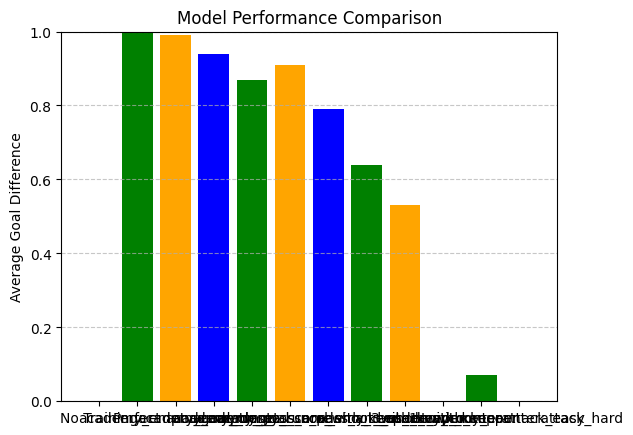

In [158]:
import matplotlib.pyplot as plt

scores = [0.0, 1.0, 0.99, 0.94, 0.87, 0.91, 0.79, 0.64, 0.53, 0, 0.07, 0]
labels = ['No Training', 'Perfect',
          'academy_empty_goal_close',
          'academy_empty_goal',
          'academy_run_to_score',
          'academy_run_to_score_with_keeper',
          'academy_pass_and_shoot_with_keeper',
          'academy_run_pass_and_shoot_with_keeper',
          'academy_3_vs_1_with_keeper',
          'academy_corner',
          'academy_counterattack_easy',
          'academy_counterattack_hard',
        ]
          
plt.bar(labels, scores, color=['blue', 'green', 'orange'])
plt.ylabel('Average Goal Difference')
plt.title('Model Performance Comparison')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()